# Algorithmic recourse for Bayesian classifiers

In [1]:
using CSV;
using DataFrames;
using LinearAlgebra;
include("../julia/utils.jl");

## Fitting the Bayesian classifier

In [2]:
include("../julia/bayes_logreg.jl");
include("../julia/optimization.jl");

In [3]:
df = CSV.read("../data/cats_dogs_large.csv", DataFrame);

For plotting we will use the R package `ggplot2` which can be readily integrated into Julia (just like many other R packages, see for example [here](https://avt.im/blog/2018/03/23/R-packages-ggplot-in-julia#fn:rcall)).

In [4]:
using RCall
@rlibrary ggplot2
@rlibrary ggimage
@rlibrary emojifont
@rlibrary viridis
@rlibrary magick

In [5]:
y = df[:,:y];
N = length(y);
X = Matrix(df[:,Not(:y)]);
X = [ones(N) X]; # add for constant
d = size(X)[2]; # number of features
w_0 = zeros(d); # zero-mean prior
λ = 0.01
H_0 = UniformScaling(λ);

In [23]:
model = bayes_logreg(X,y,w_0,H_0,𝓁,∇𝓁,∇∇𝓁);
w = model.μ;

3-element Vector{Float64}:
  0.37178464456385646
  0.33699556686193344
 -0.7459870611181132

In [7]:
step = 1;
expand = 20;
W = expandgrid((minimum(df.x1)-expand):step:(maximum(df.x1)+expand),(minimum(df.x2)-expand):step:(maximum(df.x2)+expand));
N_grid = size(W)[1];

In [8]:
y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
estimates = DataFrame(hcat(y_probit,W), :auto);
features = copy(df);
transform!(features, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

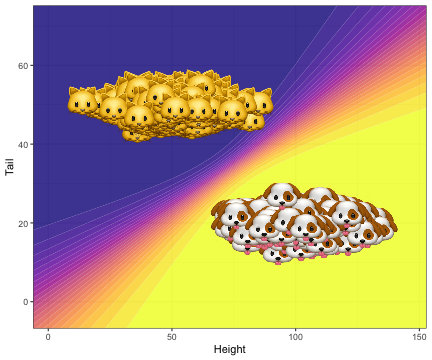

RObject{VecSxp}


In [9]:
ggplot() + 
  geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
  geom_image(data=features, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
  guides(fill="none") +
  scale_fill_viridis(option="C",discrete=true) +
  scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
  labs(x="Height", y="Tail") +
  theme_bw() # |>
  # p -> ggsave("www/predictive.png", plot = p, width=5, height=5)

## Recourse algorithm

We have our fitted logistic regression classifier $f(\mathbf{x}^\text{CF})$. The loss for our recourse objective is $\ell(f(\mathbf{x}^\text{CF}),1))$. Using Hinge loss we have

$$\ell(f(\mathbf{x}^\text{CF}),1))=(1-z\cdot logits(f(\mathbf{x}^\text{CF}),1)))_{+}$$

where $z=1$ if $y=1$ and $z=-1$ if $y=0$. Furthermore, $logits(\cdot)$ in this particular case just refers to the linear predictions that enter the sigmoid function to produce predicted probabilities. 

This yields the following gradient for our recourse problem:

$$
\begin{aligned}
&& \nabla_{\mathbf{x}^\text{CF}} \left( \ell(f(\mathbf{x}^\text{CF}),1)) \right) &= \begin{cases} -z \cdot \hat{\mathbf{w}}  & \text{if} \ \ \ \hat{\mathbf{w}}^T\mathbf{x}^\text{CF} z \le 1\\ \mathbf{0} & \text{otherwise} \end{cases} \\
\end{aligned}
$$

### Gradients

Different gradients based on different loss functions:

In [3]:
# Hinge:
function gradient(x,w,y)
    z = ifelse(y==1,1,-1)
    if z.*w'x <= 1
        𝐠 = -z .* w
    else
        𝐠 = zeros(length(w))
    end
    return 𝐠
end;

In [11]:
# Cross-entropy:
function gradient(x,w,y)
    𝐠 = w .* ((1-y)/(1-w'x)+y/(w'x))
    return 𝐠
end;

In [12]:
# Cross-entropy (on sigmoid):
function gradient(x,w,y)
    𝐠 = (𝛔(w'x) - y) .* w
    return 𝐠
end;

In [13]:
# MSE:
function gradient(x,w,y)
    𝐠 = w .* 2 * (w'x - y)
    return 𝐠
end;

In [14]:
# MSE (on sigmoid):
function gradient(x,w,y)
    𝐠 = 2 * 𝛔(w'x) * (1-𝛔(w'x)) * (𝛔(w'x) - y) .* w
    return 𝐠
end;

## Recourse

A simple structure for the output:

In [27]:
struct Recourse
    x_cf::Vector{Float64}
    path::Matrix{Float64}
end;

### Wachter et al.

In [2]:
function generate_recourse_wachter(x, gradient, w, target)
    D = length(x) # input dimension
    path = reshape(x, 1, D) # storing the path
    # Initialize:
    x_cf = copy(x) # start from factual
    t = 1 # counter
    P = zeros(D) # number of times feature is changed
    converged = predictive(vcat(1,x_cf),args...)[1] > Γ
    max_number_changes_reached = all(P.==n)
    # Recursion:
    while !converged && t < T && !max_number_changes_reached
        𝐠_t = gradient(vcat(1,x_cf),w,target)[2:length(w)] # compute gradient
        𝐠_t[P.==n] .= 0 # set gradient to zero, if already changed n times 
        i_t = argmax(abs.(𝐠_t)) # choose most salient feature
        x_cf[i_t] -= δ * sign(𝐠_t[i_t]) # counterfactual update
        P[i_t] += 1 # update 
        t += 1 # update number of times feature is changed
        converged = predictive(vcat(1,x_cf),args...)[1] .> Γ # check if converged
        println(predictive(vcat(1,x_cf),args...)[1])
        max_number_changes_reached = all(P.==n)
        path = vcat(path, reshape(x_cf, 1, D))
    end
    # Output:
    recourse = Recourse(x_cf, path) 
end;

### Schut et al. 

The algorithm used to generate recourse in Schut et al. (2021) is based on the Jacobian-based Saliency Map Attack (JSMA). Let's refer to the recourse variant as Jacobian-based Saliency Map CE (JSMCE). It can be coded up as follows:

In [15]:
function generate_recourse_schut(x,gradient,w,target,Γ,δ,n,T,predictive,args)
    D = length(x) # input dimension
    path = reshape(x, 1, D) # storing the path
    # Initialize:
    x_cf = copy(x) # start from factual
    t = 1 # counter
    P = zeros(D) # number of times feature is changed
    converged = predictive(vcat(1,x_cf),args...)[1] > Γ
    max_number_changes_reached = all(P.==n)
    # Recursion:
    while !converged && t < T && !max_number_changes_reached
        𝐠_t = gradient(vcat(1,x_cf),w,target)[2:length(w)] # compute gradient
        𝐠_t[P.==n] .= 0 # set gradient to zero, if already changed n times 
        i_t = argmax(abs.(𝐠_t)) # choose most salient feature
        x_cf[i_t] -= δ * sign(𝐠_t[i_t]) # counterfactual update
        P[i_t] += 1 # update 
        t += 1 # update number of times feature is changed
        converged = predictive(vcat(1,x_cf),args...)[1] .> Γ # check if converged
        println(predictive(vcat(1,x_cf),args...)[1])
        max_number_changes_reached = all(P.==n)
        path = vcat(path, reshape(x_cf, 1, D))
    end
    # Output:
    recourse = Recourse(x_cf, path) 
    return recourse
end;

In [16]:
function predictive(x, model=model, posterior_predictive=posterior_predictive)
    return posterior_predictive(model, x)
end

predictive (generic function with 3 methods)

## Generating recourse

In [17]:
x_F = [50.0, 60.0]; # factual
recourse = generate_recourse(x_F,gradient,model.μ,1,0.95,1,30,100,predictive,(model=model, posterior_predictive=posterior_predictive));

0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.00033535013046647816
0.0003408699818003929
0.000547250010788782
0.0008907298335448774
0.0014636546818481678
0.0024176593142536708
0.003997235259282888
0.006587555230443833
0.01077809890156307
0.017438927677701378
0.02779633700239298
0.043476950762619176
0.06646519016579545
0.07535760077570042
0.08572080614347197
0.09780832541967398
0.11190899573396557
0.12834592504812348
0.14747154307313567
0.1696568451748517
0.1952726300304543
0.22466060178112368
0.2580929935175571
0.29572127636676526
0.33751781907375666
0.38321885369792447
0.43228170234503405
0.4838718085024381
0.5368930832872413
0.5900668017221073

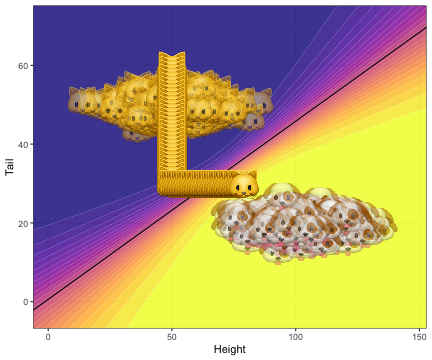

RObject{VecSxp}


In [25]:
path_df = DataFrame(recourse.path, :auto);
insertcols!(path_df, :emoji=> "../www/cat.png");
ggplot() + 
  geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
  geom_abline(intercept=1-w[1], slope=-w[2]/w[3]) +
  geom_image(data=features, aes(x=:x1, y=:x2, image=:emoji), size=0.1, image_fun=R"function(img) magick::image_fx(img, expression = '0.5*a', channel = 'alpha')") +
  geom_image(data=path_df, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
  guides(fill="none") +
  scale_fill_viridis(option="C",discrete=true) +
  scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
  labs(x="Height", y="Tail") +
  theme_bw() # |>
  # p -> ggsave("www/path.png", plot = p, width=5, height=5)